## Define ResNet

In [2]:
from tensorflow.keras.layers import Conv2D,Add, BatchNormalization,UpSampling2D, Activation, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# from cvnn import layers
# import cvnn

from pdb import set_trace
# import tensorflow_datasets as tfds
import scipy
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import cmath
import scipy.io as sio
import numpy as np

In [3]:
def avg_NSR(Y_true, Y_pred):
    signal = tf.norm(tf.reshape(Y_true, [tf.shape(Y_true)[0], -1]), axis=1)
    noise = tf.norm(tf.reshape(Y_true - Y_pred, [tf.shape(Y_true)[0], -1]), axis=1)

    return tf.math.reduce_mean(noise / signal)

In [4]:
def avg_log_SNR(Y_true, Y_pred):
    signal = tf.norm(tf.reshape(Y_true, [tf.shape(Y_true)[0], -1]), axis=1)
    noise = tf.norm(tf.reshape(Y_true - Y_pred, [tf.shape(Y_true)[0], -1]), axis=1)

    return tf.math.reduce_mean(20. * tf.math.log(signal / noise) / tf.math.log(10.0))

In [5]:
def BatchActivate(x, act=True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = BatchActivate(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = BatchActivate(shortcut, act=False)
    
    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = BatchActivate(shortcut, act=False)
    
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    # print(u.shape)
    # u = tf.keras.layers.Cropping2D(cropping=())
    c = Concatenate()([u, xskip])
    return c

In [6]:
def ResUnet(image_size,channels):
    f = [8, 16, 32, 64, 128]
    inputs = Input((image_size, image_size, 1))
    
    ## Encoder
    E0 = inputs 
    E1 = stem(E0, f[0])
    E2 = residual_block(E1, f[1], strides=2)
    print(E2.shape)
    E3 = residual_block(E2, f[2], strides=2)
    print(E3.shape)
    E4 = residual_block(E3, f[3], strides=2)
    
    E5 = residual_block(E4, f[4], strides=2)
    
    ## Bridge
    B0 = conv_block(E5, f[2], strides=1)
    print(B0.shape)
    B1 = conv_block(B0, f[2], strides=1)
    print(B1.shape)
    
    ## Decoder
    U1 = upsample_concat_block(B1, E4)

    D1 = residual_block(U1, f[2])
    U2 = upsample_concat_block(D1, E3)
    D2 = residual_block(U2, f[1])
    
    U3 = upsample_concat_block(D2, E2)
    D3 = residual_block(U3, f[2])
    
    U4 = upsample_concat_block(D3, E1)
    D4 = residual_block(U4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="relu")(D4)
    # outputs = outputs + e0
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate = 1e-3), loss=avg_NSR, metrics=[avg_log_SNR])
    return model


## Read Data

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"


In [8]:
ph_size = 128
path = "../../../Dataset/sensor_domain/Final/dataset_300/*"
test_size = 0.15

In [8]:
def read_data(path, test_size=0.25):
    
    ground_truth = []
    sensor_data = []
    count = 0
    for filename in glob.glob(path):
        mat = sio.loadmat(filename)
        truth = mat["gt"]
        sensor = mat["P"]
        
        
        # sensor_norm = mat["sensor_norm"]
        sensor_norm = sensor
        
        
        gt = truth
        # gt = np.expand_dims(gt, axis=0)
        # sensor_norm = np.expand_dims(sensor_norm, axis=0)

        temp = np.append(sensor_norm.real, sensor_norm.imag)
        temp = np.reshape(temp, (ph_size, ph_size))
        temp = np.asarray(temp)
        ground_truth.append(gt)
        sensor_data.append(temp)
    temp_gt = []
    temp_sens = []
    for i in range(len(ground_truth)):
        if np.isnan(ground_truth[i]).any() == False:
            temp_gt.append(ground_truth[i])
            temp_sens.append(sensor_data[i])
    ground_truth = temp_gt
    sensor_data = temp_sens
    
#     ground_truth = [i for i in ground_truth if np.isnan(i).any() == False]
#     sensor_data = [i for i in sensor_data if np.isnan(i).any() == False]
    
    X_train, X_test, y_train, y_test = train_test_split(sensor_data,ground_truth, test_size=test_size, random_state=22)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    # X_train = np.reshape(X_train, (np.asarray(X_train).shape[0], 1, np.asarray(X_train).shape[1]))
    # X_test = np.reshape(X_test, (np.asarray(X_test).shape[0], 1, np.asarray(X_test).shape[1]))
    # y_train = np.reshape(y_train, (np.asarray(y_train).shape[0], 1, np.asarray(y_train).shape[1]))
    # y_test = np.reshape(y_test, (np.asarray(y_test).shape[0], 1, np.asarray(y_test).shape[1]))
    # X_train = np.expand_dims(X_train, axis=-1)
    # X_test = np.expand_dims(X_test, axis=-1)
    # y_train = np.expand_dims(y_train, axis=-1)
    # y_test = np.expand_dims(y_test, axis=-1)
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = read_data(path, test_size=test_size)

print("Data read : \nX_train = {}\ny_train = {}\nX_test = {}\ny_test = {}".format(len(X_train), len(y_train), len(X_test), len(y_test)))
X_test.shape

Data read : 
X_train = 9870
y_train = 9870
X_test = 4230
y_test = 4230


(4230, 128, 128)

## Train Model

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
import matplotlib.pyplot as plt

import glob
import scipy.io
import numpy as np
from skimage.measure import profile_line
from datetime import datetime

In [11]:
input_size = 128
channels = 1
model = ResUnet(input_size,channels)

2022-08-27 08:27:38.661046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 08:27:38.664501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 08:27:38.664614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 08:27:38.664876: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(None, 64, 64, 16)
(None, 32, 32, 32)
(None, 8, 8, 32)
(None, 8, 8, 32)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1) #early stop incase no improvement in the validation loss
checkpoint = ModelCheckpoint(filepath='./model_checkpoints/', save_best_only=True, save_weights_only=True,monitor='val_avg_log_SNR', mode='max', verbose=1) # store the weights
log_csv = CSVLogger('Logs/resnet_150.csv', separator=',', append=False) #### To store the train and validation loss
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                               patience=6, min_lr=0.0000001) # reduce the learning rate incase we want

save_best_model = tf.keras.callbacks.ModelCheckpoint("Checkpoints/resnet_150.hdf5", monitor='val_loss', save_best_only=True, verbose=1)

callbacks_list = [log_csv] ### If we need early stop add that parameter here 


In [14]:
start = datetime.now()
# model = tf.keras.models.load_model("Checkpoints/model_resnet.hdf5", compile=False)
# model.compile(optimizer=Adam(learning_rate = 1e-3), loss=avg_NSR, metrics=[avg_log_SNR])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=callbacks_list)

end = datetime.now()
time_taken = end - start
print('Time: ',time_taken) 

/home/fistlab/anaconda3/envs/tf310/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-08-27 08:27:40.121559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-27 08:27:40.383423: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-08-27 08:27:40.627012: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 08:27:40.627200: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 08:27:40.627217: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-08-27 08:27:40.627454: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 08:27:40.627522: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


309/309 [==============================] - 33s 100ms/step - loss: 0.4943 - avg_log_SNR: 7.2812 - val_loss: 0.3445 - val_avg_log_SNR: 9.5867
Epoch 2/100
309/309 [==============================] - 29s 94ms/step - loss: 0.2948 - avg_log_SNR: 11.0390 - val_loss: 0.2959 - val_avg_log_SNR: 10.9233
Epoch 3/100
309/309 [==============================] - 29s 94ms/step - loss: 0.2541 - avg_log_SNR: 12.2873 - val_loss: 0.2534 - val_avg_log_SNR: 12.2857
Epoch 4/100
309/309 [==============================] - 29s 94ms/step - loss: 0.2288 - avg_log_SNR: 13.1958 - val_loss: 0.2299 - val_avg_log_SNR: 13.1630
Epoch 5/100
309/309 [==============================] - 29s 95ms/step - loss: 0.2120 - avg_log_SNR: 13.8761 - val_loss: 0.2124 - val_avg_log_SNR: 13.8256
Epoch 6/100
309/309 [==============================] - 29s 95ms/step - loss: 0.2000 - avg_log_SNR: 14.3657 - val_loss: 0.2101 - val_avg_log_SNR: 13.9381
Epoch 7/100
309/309 [==============================] - 29s 95ms/step - loss: 0.1937 - avg_log_S

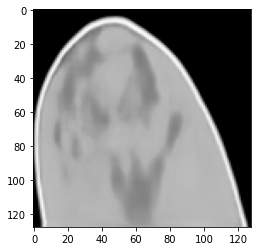

In [15]:
x=31

test = model.predict(np.expand_dims(X_test[x], axis=0))
plt.imshow(test.squeeze(), cmap='gray')


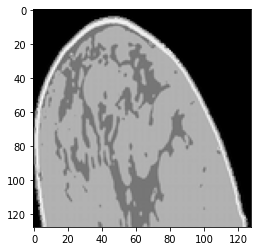

In [16]:
train = y_test[x]
plt.imshow(train, cmap='gray')

In [17]:
model.save("Checkpoints/resnet_final_150")

2022-08-27 09:15:51.930174: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Checkpoints/resnet_final_150/assets


/home/fistlab/anaconda3/envs/tf310/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [18]:
# mat = sio.loadmat('test/1.mat')
# mat['P'].shape

In [9]:
def read_data(path, test_size=0.25):
    
    ground_truth = []
    sensor_data = []
    count = 0
    for filename in glob.glob(path):
        mat = sio.loadmat(filename)
        truth = mat["gt"]
        sensor = mat["P"]

        # sensor = normalize_sensor_data(sensor)
        
        
        # gt = (truth - min_gt) / (max_gt - min_gt)
        # gt = np.expand_dims(gt, axis=0)
        # sensor_norm = np.expand_dims(sensor_norm, axis=0)
        temp = sensor
        # print(temp.shape)
        # temp = np.append(sensor.real, sensor.imag)

        # P_min = np.amin(temp)
        # P_max = np.amax(temp)

        # sensor_norm = (temp - P_min) / (temp - P_min)
        # temp = sensor_norm

        # temp = np.reshape(temp, (ph_size, ph_size))
        temp = np.asarray(temp)
        ground_truth.append(truth)
        sensor_data.append(temp)
    temp_gt = []
    temp_sens = []
    for i in range(len(ground_truth)):
        if np.isnan(ground_truth[i]).any() == False:
            temp_gt.append(ground_truth[i])
            temp_sens.append(sensor_data[i])
    ground_truth = temp_gt
    sensor_data = temp_sens
    
#     ground_truth = [i for i in ground_truth if np.isnan(i).any() == False]
#     sensor_data = [i for i in sensor_data if np.isnan(i).any() == False]
    
    X_train, X_test, y_train, y_test = train_test_split(sensor_data,ground_truth, test_size=test_size, random_state=22)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    # X_train = np.reshape(X_train, (np.asarray(X_train).shape[0], 1, np.asarray(X_train).shape[1]))
    # X_test = np.reshape(X_test, (np.asarray(X_test).shape[0], 1, np.asarray(X_test).shape[1]))
    # y_train = np.reshape(y_train, (np.asarray(y_train).shape[0], 1, np.asarray(y_train).shape[1]))
    # y_test = np.reshape(y_test, (np.asarray(y_test).shape[0], 1, np.asarray(y_test).shape[1]))
    # X_train = np.expand_dims(X_train, axis=-1)
    # X_test = np.expand_dims(X_test, axis=-1)
    # y_train = np.expand_dims(y_train, axis=-1)
    # y_test = np.expand_dims(y_test, axis=-1)
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = read_data(path, test_size=test_size)

print("Data read : \nX_train = {}\ny_train = {}\nX_test = {}\ny_test = {}".format(len(X_train), len(y_train), len(X_test), len(y_test)))
X_test.shape

Data read : 
X_train = 4460
y_train = 4460
X_test = 788
y_test = 788


(788, 128, 64)

In [22]:
x = 783
sio.savemat('test_300/10.mat', dict(P=X_test[x], gt=y_test[x]))

